# Decision tree и Random forest

Реализовать 2 класса DecisionTreeClassifier и RandomForestClassifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score
%matplotlib inline
from sklearn.model_selection import KFold

In [2]:
import warnings

def handle_warning(message, category, filename, lineno, file=None, line=None):
    print('A warning occurred:')
    print(message)
    print('Do you wish to continue?')

    while True:
        response = raw_input('y/n: ').lower()
        if response not in {'y', 'n'}:
            print('Not understood.')
        else:
            break

    if response == 'n':
        raise category(message)
        
warnings.showwarning = handle_warning

## Подготовка тестовых данных

In [3]:
X = np.array([[1, 1], [1.5, 1], [1.5, 2], [1, 1.5], # 0
              [5.5, 3.5],                           # 1
              [2.5, 1.5],                           # 0
              [3, 2.5], [6, 3], [5, 3],             # 1
              [4, 3], [2, 1], [2, 2],               # 0
              [5, 4], [6, 3], [5, 2.5]])            # 1

Y = np.array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1])

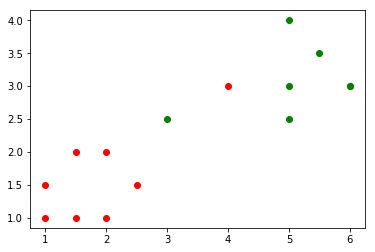

In [4]:
plt.figure(1)
for i in range(X.shape[0]):
    clr = 'green'
    if (Y[i] == 0):
        clr = 'red'
    plt.plot(X[i][0], X[i][1], marker='o', color=clr, ls='')
plt.show()

In [5]:
A = np.array([[1, 18, 88], [1, 22, 56], [0, 19, 78], [1, 11, 54], [0, 21, 76], [1, 24, 92], [1, 20, 65]])
B = np.array([1, 0, 1, 0, 1, 1, 0])

## Реализация вспомогательных функций

### Разделение массивов данных на части (splitByEdge)
Разрезает входные вектора на две части по измерению (признаку) dim, по границе edge, с минимальным количеством отделяемых элементов min_spl. В случае слишком малого числа элементов разделенной выборки возвращает None.

In [6]:
def splitByEdge(x, y, dim, edge, min_spl):
    xl, yl, xr, yr = [], [], [], []
    for i in range(x.shape[0]):
        if (x[i][dim] > edge):
            xr.append(list(x[i]))
            yr.append(y[i])
        else:
            xl.append(list(x[i]))
            yl.append(y[i])
    if (len(yl) < min_spl or len(yr) < min_spl):
        return None
    return np.array([[xl, yl],[xr, yr]])

In [7]:
tst = splitByEdge(X, Y, 1, 2.8, 1)

if (tst is not None):
    print tst[0][0]
    print tst[0][1]
    print 
    print tst[1][0]
    print tst[1][1]

[[1.0, 1.0], [1.5, 1.0], [1.5, 2.0], [1.0, 1.5], [2.5, 1.5], [3.0, 2.5], [2.0, 1.0], [2.0, 2.0], [5.0, 2.5]]
[0, 0, 0, 0, 0, 1, 0, 0, 1]

[[5.5, 3.5], [6.0, 3.0], [5.0, 3.0], [4.0, 3.0], [5.0, 4.0], [6.0, 3.0]]
[1, 1, 1, 0, 1, 1]


### Подсчет статистики классификатора clf по случайным разбиениям

In [8]:
def countStat(x, y, clf, n=5, decision_threshold=0.0):
    
    gkf = KFold(n_splits=n, shuffle=True)
    
    print ("| %20s | %20s | %20s |" % ("accuracy", "recall", "precision"))

    for train, test in gkf.split(x, y):
        X_train, y_train = x[train], y[train]
        X_test, y_test = x[test], y[test]

        clf.fit(X_train, y_train)

        pr_raw = clf.predict(X_test)
        
        pr = np.around(pr_raw + decision_threshold)

        accuracy = accuracy_score(y_pred=pr, y_true=y_test)
        recall = recall_score(y_test, pr)
        precision = precision_score(y_test, pr)

        print ("| %20f | %20f | %20f |" % (accuracy, recall, precision))

### Статистические функции
P - возвращает доли элементов классов
H - возвращает расчет критерия разбиения
G - возвращает расчет неоднородности узла

In [9]:
#----------------------------------------------------------
def P(y, x_count, c_count, c_start):
    p = np.array([0.0 for yo in range(c_count)])
    for i in range(c_count):
        for it in y:
            if (it == i+c_start):
                p[i] += 1
    for i in range(c_count):
        p[i] /= x_count
    return p
#----------------------------------------------------------
def H(p, type='gini'):
    if (type == 'gini'):
        r = 2
        for i in p:
            r *= i
        return r
    elif (type == 'entropy'):
        r = 0
        for i in p:
            r -= i*np.log(i)
        return r
    else:
        return 1 - p.max()
#----------------------------------------------------------
def G(pl, pr, xl, xr, xo):
    kl = (xl + 0.0) / xo
    kr = (xr + 0.0) / xo
    return kl*H(pl) + kr*H(pr)
#----------------------------------------------------------

### Структура для хранения результатов обучения

In [10]:
class TreeNode:
    def __init__(self, edge, attr, left, right):
        self.edge = edge
        self.attr = attr
        self.left = left
        self.right = right

## DecisionTreeClassifier

In [11]:
class DecisionTreeClassifier():
    
    def __init__(self, max_depth=16, min_samples_split=2, count_split=10, dim_start=0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.count_split = count_split
        self.c_count = 2
        self.c_start = 0
        self.x_count = 0
        self.dim_pass = dim_start
        self.bintree = None
        
    def tree(self, x, y, depth):
        if (depth > self.max_depth or x.shape[0] < 2 * self.min_samples_split or len(x.shape) <= 1):
            return None
        min_att = x.min(axis=0)
        max_att = x.max(axis=0)
        dim = (self.dim_pass + depth) % x.shape[1]
        l = min_att[dim]
        r = max_att[dim]
        dh = r - l + 0.0
        s = dh / self.count_split
        tk = 1.0
        te = (l + r) / 2
        while (r+s <= l):
            self.dim_pass += 1
            dim = (self.dim_pass + depth) % x.shape[1]
            l = min_att[dim]
            r = max_att[dim]
            dh = r - l + 0.0
            s = dh / self.count_split
            tk = 1.0
            te = (l + r) / 2
            if (self.dim_pass > x.shape[1]*depth):
                return None
        for ed in np.arange(l, r + s, s):
            seg = splitByEdge(x, y, dim, ed, self.min_samples_split)
            if (seg is not None):
                pl = P(seg[0][1], self.x_count, self.c_count, self.c_start)
                pr = P(seg[1][1], self.x_count, self.c_count, self.c_start)
                xl = np.array(seg[0][0]).shape[0]
                xr = np.array(seg[1][0]).shape[0]
                tm = G(pl, pr, xl, xr, x.shape[0])
                if (tm < tk):
                    tk = tm
                    te = ed
        if (tk == 1.0):
            return None
        seg = splitByEdge(x, y, dim, te, self.min_samples_split)
        left = self.tree(np.array(seg[0][0]), np.array(seg[0][1]), depth+1)
        right = self.tree(np.array(seg[1][0]), np.array(seg[1][1]), depth+1)
        if (left is None):
            left = P(seg[0][1], self.x_count, self.c_count, self.c_start)
        if (right is None):
            right = P(seg[1][1], self.x_count, self.c_count, self.c_start)
        return TreeNode(te, dim, left, right)
        
        
    def fit(self, x, y):
        self.c_count = len(set(y))
        if (self.c_count > 2):
            warnings.warn("Too many classes for binary decision tree", RuntimeWarning)
            return None
        self.c_start = y.min()
        self.x_count = x.shape[0]
        self.bintree = self.tree(x, y, 0)
        return self
                
    
    def solve(self, bt, elem):
        if (isinstance(bt, TreeNode)):
            if (elem[bt.attr] > bt.edge):
                return self.solve(bt.right, elem)
            else:
                return self.solve(bt.left, elem)
        else:
            if (bt[0] > bt[1]):
                return 0
            else:
                return 1
    
    def predict(self, x):
        y = np.array([self.c_start for i in range(x.shape[0])])
        if (self.bintree is None):
            warnings.warn("No data or only one class", RuntimeWarning)
        else:
            for i in range(x.shape[0]): 
                y[i] = self.solve(self.bintree, x[i])
        return y

### Двумерный случай

In [12]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X, Y)
print clf.predict(X)
print Y

[0 0 0 0 1 0 1 1 1 1 0 0 1 1 1]
[0 0 0 0 1 0 1 1 1 0 0 0 1 1 1]


### Трехмерный случай

In [13]:
clf = DecisionTreeClassifier()
clf.fit(A, B)
print clf.predict(A)
print B

[1 0 1 1 1 0 0]
[1 0 1 0 1 1 0]


### Разбиение на выборки и подсчет ошибок

In [14]:
gkf = KFold(n_splits=5, shuffle=True)

In [15]:
clf = DecisionTreeClassifier()

for x in range(2):
    for train, test in gkf.split(X, Y):
        X_train, Y_train = X[train], Y[train]
        X_test, Y_test = X[test], Y[test]

        clf.fit(X_train, Y_train)

        print clf.predict(X_test)
        print Y_test
        print "accuracy: ", accuracy_score(y_pred=clf.predict(X_test), y_true=Y_test)

[0 1 0]
[0 0 0]
accuracy:  0.666666666667
[0 1 1]
[0 1 1]
accuracy:  1.0
[0 1 1]
[0 1 1]
accuracy:  1.0
[0 0 0]
[0 1 0]
accuracy:  0.666666666667
[0 1 1]
[0 1 1]
accuracy:  1.0
[0 1 1]
[0 0 0]
accuracy:  0.333333333333
[0 0 1]
[0 0 1]
accuracy:  1.0
[1 1 1]
[1 1 1]
accuracy:  1.0
[0 1 0]
[0 1 1]
accuracy:  0.666666666667
[0 1 0]
[0 1 0]
accuracy:  1.0


### Обучение и тестирование на одинаковых данных

In [16]:
clf = DecisionTreeClassifier()

clf.fit(X, Y)
    
pr = clf.predict(X)
print pr
print Y

accuracy = accuracy_score(y_pred=pr, y_true=Y)
recall = recall_score(Y, pr)
precision = precision_score(Y, pr)

print ("| %20s | %20s | %20s |" % ("accuracy", "recall", "precision"))
print ("| %20f | %20f | %20f |" % (accuracy, recall, precision))

[0 0 0 0 1 0 1 1 1 1 0 0 1 1 1]
[0 0 0 0 1 0 1 1 1 0 0 0 1 1 1]
|             accuracy |               recall |            precision |
|             0.933333 |             1.000000 |             0.875000 |


### Обработка большого датасета

In [17]:
df = pd.read_csv('./data/cs-training.csv', sep=',')
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [18]:
df = df.dropna()
X = df.as_matrix(columns=df.columns[1:])
Y = df.as_matrix(columns=df.columns[:1])
Y = Y.reshape(Y.shape[0])

#### Максимальная глубина = 8, количество пре-разбиений внутри каждого признака = 6

In [19]:
clf = DecisionTreeClassifier(max_depth=8, count_split=6)
countStat(X, Y, clf, 5)

|             accuracy |               recall |            precision |
|             0.929825 |             0.009541 |             0.372093 |
|             0.931820 |             0.071600 |             0.550926 |
|             0.931529 |             0.140330 |             0.557377 |
|             0.930448 |             0.162602 |             0.547945 |
|             0.935476 |             0.138125 |             0.560914 |


#### Максимальная глубина = 1, количество пре-разбиений внутри каждого признака = 3

In [20]:
clf = DecisionTreeClassifier(max_depth=1, count_split=3)
countStat(X, Y, clf, 5)

|             accuracy |               recall |            precision |
A warning occurred:
Precision is ill-defined and being set to 0.0 due to no predicted samples.
Do you wish to continue?
y/n: y
|             0.932319 |             0.000000 |             0.000000 |
|             0.932444 |             0.000000 |             0.000000 |
|             0.930365 |             0.000000 |             0.000000 |
|             0.929617 |             0.000000 |             0.000000 |
|             0.927826 |             0.000000 |             0.000000 |


#### Максимальная глубина = 12, количество пре-разбиений внутри каждого признака = 6

In [21]:
clf = DecisionTreeClassifier(max_depth=12, count_split=6)
countStat(X, Y, clf, 5)

|             accuracy |               recall |            precision |
|             0.931072 |             0.114589 |             0.549575 |
|             0.928993 |             0.103226 |             0.495775 |
|             0.932070 |             0.003690 |             0.300000 |
|             0.931113 |             0.179502 |             0.526957 |
|             0.932566 |             0.158663 |             0.523046 |


#### Максимальная глубина = 24, количество пре-разбиений внутри каждого признака = 7

In [22]:
clf = DecisionTreeClassifier(max_depth=24, count_split=7)
countStat(X, Y, clf, 5)

|             accuracy |               recall |            precision |
|             0.932901 |             0.113665 |             0.494595 |
|             0.930448 |             0.110194 |             0.534286 |
|             0.930947 |             0.114764 |             0.612308 |
|             0.931778 |             0.093093 |             0.541958 |
|             0.931360 |             0.024833 |             0.500000 |


## RandomForestClassifier

In [23]:
class RandomForestClassifier():
    
    def __init__(self, count_trees=5, batch_size=5, count_split=5, rst=0):
        self.count_trees = count_trees
        self.batch_size = batch_size
        self.count_split = count_split
        self.rst = rst
        self.dtree = [None for _ in range(count_trees)]
        
    def fit(self, x, y):
        ran = np.random.RandomState(self.rst)
        count_attr = int(np.around(np.sqrt(x.shape[1])))
        for i in range(self.count_trees):
            rxi = ran.randint(low=0, high=x.shape[0], size=self.batch_size) # random x-element indexes
            rai = ran.randint(low=0, high=x.shape[1], size=count_attr)      # random attribute indexes
            ux = x[rxi]
            uy = y[rxi]
            for it in ux:
                it = it[rai]
            self.dtree[i] = DecisionTreeClassifier(max_depth=count_attr, count_split=5).fit(ux, uy)
        return self
    
    def predict(self, x):
        y = np.array([0.0 for _ in range (x.shape[0])])
        for tree in self.dtree:
            p = tree.predict(x)
            y[np.where(p == 1)] += 1
        y = y / self.count_trees
        return y

### Тестирование на целом датасете

In [24]:
clf = RandomForestClassifier(count_trees=200, batch_size=1000, rst=0)
clf.fit(X, Y)
pr_raw = clf.predict(X)

In [25]:
decision_threshold = 0.36 # Коэффициент принятия решения об отнесении к более редкому классу

pr = np.around(pr_raw + decision_threshold)

accuracy = accuracy_score(y_pred=pr, y_true=Y)
recall = recall_score(Y, pr)
precision = precision_score(Y, pr)

print ("| %20s | %20s | %20s |" % ("accuracy", "recall", "precision"))
print ("| %20f | %20f | %20f |" % (accuracy, recall, precision))

|             accuracy |               recall |            precision |
|             0.930423 |             0.001556 |             0.351351 |


### Тестирование на частях датасета

In [26]:
clf = RandomForestClassifier(count_trees=200, batch_size=1000, rst=0)
countStat(X, Y, clf, 5, decision_threshold=0.36)

|             accuracy |               recall |            precision |
|             0.930989 |             0.000000 |             0.000000 |
|             0.927954 |             0.004115 |             0.152174 |
|             0.931446 |             0.009208 |             0.300000 |
|             0.929201 |             0.007156 |             0.240000 |
|             0.929115 |             0.005914 |             0.294118 |


In [28]:
clf = RandomForestClassifier(count_trees=200, batch_size=1000, rst=0)
countStat(X, Y, clf, 5, decision_threshold=0.45)

|             accuracy |               recall |            precision |
|             0.925501 |             0.025470 |             0.185022 |
|             0.924753 |             0.024633 |             0.222222 |
|             0.924462 |             0.021661 |             0.158590 |
|             0.923547 |             0.031534 |             0.176871 |
|             0.921382 |             0.018322 |             0.118774 |


In [31]:
clf = RandomForestClassifier(count_trees=200, batch_size=1000, rst=0)
countStat(X, Y, clf, 5, decision_threshold=0.44)

|             accuracy |               recall |            precision |
|             0.924129 |             0.019631 |             0.157143 |
|             0.928162 |             0.014432 |             0.212389 |
|             0.926166 |             0.023256 |             0.174312 |
|             0.924545 |             0.020371 |             0.158879 |
|             0.924625 |             0.028070 |             0.241206 |
